In [2]:
#@title Tokenizer
from keras.preprocessing.text import Tokenizer
import numpy as np

def load_tokenizers():
  with open("Input_data/tokens.txt", "r", encoding="utf-8") as file:
      file_content = file.read()
  tokens = file_content.encode("ascii", "ignore").decode("utf-8")
  tokenizer = Tokenizer(filters='\n')
  tokenizer.fit_on_texts([tokens])

  return tokenizer

tokenizer = load_tokenizers()

print(len(tokenizer.word_index))
tokenizer.word_index

# example usage:
#temp = tokenizer.texts_to_sequences([temp])
#temp = np.array(temp_Y[0])
#temp = tokenizer.sequences_to_texts([temp])

546


{'!stop!': 1,
 '!': 2,
 '#': 3,
 '$': 4,
 '%': 5,
 '&': 6,
 "'": 7,
 '(': 8,
 ')': 9,
 '*': 10,
 ',': 11,
 '.': 12,
 '/': 13,
 '?': 14,
 '@': 15,
 '[': 16,
 '\\': 17,
 ']': 18,
 '^': 19,
 '_': 20,
 '`': 21,
 ':': 22,
 ';': 23,
 '{': 24,
 '|': 25,
 '}': 26,
 '~': 27,
 '00spaces': 28,
 '02spaces': 29,
 '04spaces': 30,
 '06spaces': 31,
 '08spaces': 32,
 '10spaces': 33,
 '12spaces': 34,
 '14spaces': 35,
 '16spaces': 36,
 '18spaces': 37,
 '20spaces': 38,
 '22spaces': 39,
 '24spaces': 40,
 '26spaces': 41,
 '28spaces': 42,
 '30spaces': 43,
 '32spaces': 44,
 '34spaces': 45,
 '36spaces': 46,
 '38spaces': 47,
 '40spaces': 48,
 '>': 49,
 '<': 50,
 '<!doctype': 51,
 '</a': 52,
 '</abbr': 53,
 '</address': 54,
 '</area': 55,
 '</article': 56,
 '</aside': 57,
 '</audio': 58,
 '</b': 59,
 '</base': 60,
 '</bdi': 61,
 '</bdo': 62,
 '</blockquote': 63,
 '</body': 64,
 '</br': 65,
 '</button': 66,
 '</canvas': 67,
 '</caption': 68,
 '</cite': 69,
 '</code': 70,
 '</col': 71,
 '</colgroup': 72,
 '</data'

##PlantUML preprocessing

In [3]:
#@title find all identifiers like _"listitem3"_ and give every identifier a placeholder like _"id28"_
import re

def find_identifiers(string):
    pattern = r"\bobject\b\s+(\w+)"
    object_words = re.findall(pattern, string, flags=re.IGNORECASE)
    unique_words = list(set(object_words)) #shuould be not necessary
    object_dict = {f"id{i+1}": word for i, word in enumerate(unique_words)}
    #object_dict = {k: v for k, v in sorted(object_dict.items(), key=lambda item: len(item[1]), reverse=True)}

    return object_dict

In [4]:
#@title split PlantUML into: non-network importent - element types - element structure
import re

def split_PlantUML(string):
    string = string.replace("@startuml", "")
    string = string.replace("@enduml", "")
    substrings = string.split("'SPLIT")

    return substrings[0].strip(), substrings[1].strip(), substrings[2].strip()

In [5]:
#@title Transform _element_type_ and _element_order_ into a list of identifiers pairs
import re
import numpy as np

def prepair_uml_input(string, identifiers):
    string = string.replace("--> ", "")
    string = string.replace(">", "")
    string = string.replace(": ", "")
    string = string.replace("\n", " ")

    for key, value in identifiers.items():
      pattern = r'\b{}\b'.format(re.escape(value))
      string = re.sub(pattern, key, string)

    #tokens = plant_uml_tokenizer.texts_to_sequences([string])[0]
    #tokens = np.array(tokens)
    #tokens = np.reshape(tokens, (-1, 2))

    return string

In [6]:
#@title Everything as one method
def plant_uml_preprocessing(plant_uml_string):
  plant_uml_tokenizer = load_tokenizers()
  identifiers = find_identifiers(plant_uml_string)
  stuff_for_post_processing, element_type, element_order = split_PlantUML(plant_uml_string)
  element_type_tokens = prepair_uml_input(element_type, identifiers)
  element_order_tokens = prepair_uml_input(element_order, identifiers)

  return stuff_for_post_processing, identifiers, element_type_tokens, element_order_tokens

##HTML preprocessing

---

**1.** we need to remove stuff that is inserted after generating (or placeholders):
- [X] **text**
- [X] **indents**
- [X] **comments**
- [X] href = " "
- [X] rel = " "
- [X] type = " "
- [X] method = " "
- [X] alt = " "
- [X] names = " "
- [X] for = " "
- [X] action = " "
- [X] placeholder = ""
- [X] src = ""
- [X] value = ""
- [X] script = ""
- [X] target = ""

we need placeholder id's:
- [X] id = " "

**2.** we use spaces to seperate the sting at certain places for a better tokenizer

**3.** we count the number of indentations and replace them with "00SPACES"

**4.** we are adding a \<STOP> token to the html

---

In [7]:
#@title \<body> only
def cut_body(string):
    start_tag = '<body'
    end_tag = '/body>'

    start_index = string.find(start_tag)
    if start_index == -1:
        return ""  # Return an empty string if start tag not found

    end_index = string.find(end_tag, start_index + len(start_tag))
    if end_index == -1:
        return ""  # Return an empty string if end tag not found

    return string[start_index:end_index + len(end_tag)].strip()

In [8]:
#@title remove comments
import re

def remove_html_comments(string):
    pattern = r"<!--(.*?)-->"
    return re.sub(pattern, "", string)

In [9]:
#@title stop token
def add_stop_token(string):
  return string + "\n!STOP!"

In [10]:
#@title add spaces behind and infront of special characters - remove double space afterwards
import re
def whitespace_seperator(string):

  string = string.replace("<", " <")
  string = string.replace("  <", " <")

  string = string.replace(">", " >  ")
  string = string.replace(">  ", "> ")

  string = string.replace("-", " - ")

  string = string.replace("=", "  =  ")
  string = string.replace("  =", " =")
  string = string.replace("=  ", "= ")

  string = string.replace("\"", " \" ")
  string = string.replace("  \"", " \"")
  string = string.replace("\"  ", "\" ")

  string = string.replace("\'", " \' ")
  string = string.replace("  \'", " \'")
  string = string.replace("\'  ", "\' ")

  string = string.replace("\\n", " \\n ")

  return string

In [11]:
#@title remove text in html
import re

def remove_content(string):
    string = string.replace("\n", "<\n")
    pattern = r'>[^<]*<'
    string = re.sub(pattern, '> <', string)
    string = string.replace("<\n", "\n")
    return string

In [12]:
#@title remove any type of attribute (??? = " ... ") if necessary
import re

def remove_attribute(attribute, string):
    pattern = r'{}\s*=\s*"[^"]*"'.format(re.escape(attribute))
    return re.sub(pattern, '', string)

In [13]:
#@title replace id = " ... " with the same placeholders from PlantUML
import re

def id_placeholders(string, identifiers):
  for key, value in identifiers.items():
    string = string.replace("id = \" " + value + " \"", key)

  return string

In [14]:
#@title remove \<script>
def remove_script(string):
  string = string.replace("</script >", "")
  string = string.replace("</script>", "")
  string = string.replace("<script  >", "")
  string = string.replace("<script >", "")
  string = string.replace("<script>", "")
  string = string.replace("script", "")
  string = string.replace("<>", "")
  string = string.replace("< >", "")
  return string

In [15]:
#@title replace spaces and indents
import re

def indent_tokenize(string):

  # replace \t
  string = string.replace("\t", "    ")

  # replace double breaks
  string = string.replace("\n\n", "\n")
  string = string.replace("\n \n", "\n")

  # stack indents
  lines = string.split("\n")
  new_lines = []
  for i in range(len(lines)):
      line = lines[i]
      if line.strip() == '':
        continue
      indent_count = len(line) - len(line.lstrip(' '))
      if indent_count % 2 != 0:
        indent_count -= 1
      indent_spaces = f"{indent_count:02d}SPACES "
      new_lines.append(line.replace(" " * indent_count, indent_spaces, 1))
  string = "\n".join(new_lines)

  # remove remaining multiple instances of spaces
  string = re.sub(r' +', ' ', string.replace('\n', ' \n')).strip()

  return string

In [16]:
#@title Everything as one method
def html_preprocessing(string, identifiers): # identifiers from PlantUML
  string = cut_body(string)
  string = remove_html_comments(string)
  string = add_stop_token(string)
  string = whitespace_seperator(string)
  string = remove_content(string)
  string = remove_attribute("href", string)
  string = remove_attribute("rel", string)
  string = remove_attribute("type", string)
  string = remove_attribute("method", string)
  string = remove_attribute("alt", string)
  string = remove_attribute("name", string)
  string = remove_attribute("for", string)
  string = remove_attribute("action", string)
  string = remove_attribute("placeholder", string)
  string = remove_attribute("src", string)
  string = remove_attribute("value", string)
  string = remove_attribute("style", string)
  string = remove_attribute("script", string)
  string = remove_attribute("target", string)
  string = remove_script(string)
  string = indent_tokenize(string)
  string = id_placeholders(string, identifiers) # identifiers from PlantUML
  string = remove_attribute("id", string)

  return string

#Encode all chars as one-hot <font color='red'>`DEPRECATED`</font>

### ASCII Text -> ASCII Numbers

In [17]:
#@title
def encode_ascii(text):
    encoded_text = []
    for char in text:
        # Normalization
        encoded_text.append(ord(char)/128)
    return encoded_text

# Example usage
text = "<div>\n<h1>Hi</h1>"
encoded_text = encode_ascii(text)
print(encoded_text)
text = "<HTML> <H1> My Website"

[0.46875, 0.78125, 0.8203125, 0.921875, 0.484375, 0.078125, 0.46875, 0.8125, 0.3828125, 0.484375, 0.5625, 0.8203125, 0.46875, 0.3671875, 0.8125, 0.3828125, 0.484375]


In [18]:
#@title
def encode_ascii2(text):
    encoded_text = []
    for char in text:
        binary_char = bin(ord(char))[2:]  # Get binary representation without '0b' prefix
        padded_binary_char = binary_char.zfill(8)  # Pad with leading zeros to make it 8 bits
        encoded_char = str(char) + ' = ' + padded_binary_char
        encoded_text.append(encoded_char)
    return encoded_text

# Example usage
text = "<div>\n<h1>Hi</h1>"
encoded_text2 = encode_ascii2(text)
for element in encoded_text2:
    print(element)

< = 00111100
d = 01100100
i = 01101001
v = 01110110
> = 00111110

 = 00001010
< = 00111100
h = 01101000
1 = 00110001
> = 00111110
H = 01001000
i = 01101001
< = 00111100
/ = 00101111
h = 01101000
1 = 00110001
> = 00111110


ASCII Text -> One Hot Code

In [19]:
#@title
import numpy as np

def ascii_one_hot_encode(text, start_token=False, end_token=True):
    num_chars = 128  # Number of ASCII characters (0-127)

    one_hot_vectors = []

    if start_token:
        end_token_vector = np.zeros(num_chars + 1, dtype=int)
        end_token_vector[num_chars] = 1  # Set the last position as 1 for the end-token
        one_hot_vectors.append(end_token_vector)

    for char in text:
        vector = np.zeros(num_chars + 1, dtype=int)  # Add one extra position for the end-token
        vector[ord(char)] = 1
        one_hot_vectors.append(vector)

    if end_token:
        end_token_vector = np.zeros(num_chars + 1, dtype=int)
        end_token_vector[num_chars] = 1  # Set the last position as 1 for the end-token
        one_hot_vectors.append(end_token_vector)

    return np.vstack(one_hot_vectors)

# Example usage
text = "Hello, world!"
one_hot_vectors = ascii_one_hot_encode(text)
print(one_hot_vectors)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


One Hot Code -> Padding

In [20]:
#@title
import numpy as np

def padding(array, padding_lenght):
    current_rows = array.shape[0]
    last_row = array[-1]

    if current_rows >= padding_lenght:  #thats to long :(
        print("to long for training")
        return array

    repeat_count = padding_lenght - current_rows
    repeated_rows = np.tile(last_row, (repeat_count, 1))

    return np.concatenate((array, repeated_rows), axis=0)

Split 2D numpy data randomly -> Partial tokens and next token

In [21]:
#@title
import numpy as np

def split_Y_tokens(array):
    num_rows = array.shape[0]

    # Select a random row index
    random_index = np.random.randint(0, num_rows)

    # Split the array into two parts
    partial_tokens = array[:random_index, :]
    next_token = array[random_index, :]

    return partial_tokens, next_token

##Build Data Set from one Training Pair (for char-encoding)
(List + HTML)

In [22]:
#@title
import numpy as np

def create_dataset(X, Y):

    # PADDING
    padding = np.full((129,), -1)

    # STOP TOKEN
    stop_token_row = np.zeros((1, 129))
    stop_token_row[0, -1] = 1

    # DATA SIZE: Get the number of rows in Y
    data_size = Y.shape[0]

    # Transform X into a three-dimensional numpy array
    # Soft Copy
    X = np.tile(X, (1, 1, 1))
    X = tf.repeat(X, repeats=data_size, axis=0)

    # Transform Y into a three-dimensional numpy array (Z)
    # Hard Copy
    Z = np.tile(Y, (data_size, 1, 1))

    # Z Padding
    for i in range(data_size):
      #Z[i, i:, :] = stop_token_row
      Z[i, i:, :] = padding

    # Placeholder return value
    return X, Z, Y


# Build Training Pairs

create one training pair

In [25]:
#@title
import numpy as np
import tensorflow as tf
import random

def create_dataset():

    number = random.randint(1, 30)
    print("plantUML nr " + str(number))
    with open(f"drive/MyDrive/Webgen/PlantUML_versuch/training_pairs/plantUML/{number}.txt", "r", encoding="windows-1255") as file:
        file_content = file.read()
    input = file_content.encode("ascii", "ignore").decode("utf-8")

    '''
    # generate ground truth in place
    output = generator(input)
    '''

    # take the previous generated htmls
    with open(f"drive/MyDrive/Webgen/PlantUML_versuch/training_pairs/html/{number}.html", "r", encoding="utf-8") as file:
        file_content = file.read()
    output = file_content.encode("ascii", "ignore").decode("utf-8")

    _, identifiers, type_input, order_input = plant_uml_preprocessing(input)
    html = html_preprocessing(output, identifiers)

    # tokenizing
    # tokenizer = load_tokenizers()
    type_input  = np.array(tokenizer.texts_to_sequences([type_input] ))[0]
    order_input = np.array(tokenizer.texts_to_sequences([order_input]))[0]
    html_output = np.array(tokenizer.texts_to_sequences([html]       ))[0]

    # DATA SIZE: Get the number of tokens in html - token sequence
    data_size = len(html_output)

    # Transform type_input into a two-dimensional numpy array
    # Soft Copy
    type_input = np.tile(type_input, (1, 1))
    type_input = tf.repeat(type_input, repeats=data_size, axis=0)

    # Transform order_input into a two-dimensional numpy array
    # Soft Copy
    order_input = np.tile(order_input, (1, 1))
    order_input = tf.repeat(order_input, repeats=data_size, axis=0)

    # Transform html_input into a two-dimensional numpy array
    # Hard Copy
    html_input = np.tile(html_output, (data_size, 1))

    # html_input Padding
    for i in range(data_size):
      html_input[i, i:] = 0

    return [type_input, order_input, html_input], html_output

example

In [26]:
#@title
 # inputs, outputs = create_dataset()

# Model <font color='GREEN'>`GLOBAL VARIABLE`</font> <font color='ORANGE'>`NEW COMPILED MODEL`</font>

### imports

In [27]:
#@title !pip install keras-nlp
#!pip install keras-nlp --upgrade # for positional encoding
#import keras_nlp

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import regularizers
from keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalMaxPooling2D, Input, UpSampling2D, Attention, MultiHeadAttention, Concatenate, Reshape, CategoryEncoding
from tensorflow.keras.models import Model

In [29]:
import tensorflow
import keras
import keras.layers as layers
from keras.layers import Conv2D, Dense, Flatten, GlobalMaxPooling2D, Input, UpSampling2D, Attention, MultiHeadAttention, Concatenate, Reshape, CategoryEncoding
from keras.models import Model

## create model

https://keras.io/examples/timeseries/timeseries_transformer_classification/
https://keras.io/examples/nlp/neural_machine_translation_with_transformer/

https://medium.com/@max_garber/simple-keras-transformer-model-74724a83bb83
https://colab.research.google.com/drive/1CBe2VlogbyXzmIyRQGH5xzuvLwGrvjcf?usp=sharing

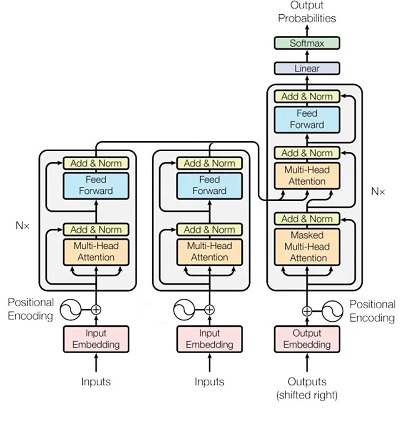

### lstm doppel encoder transformer

In [30]:
def create_model_ohne_dropout(token_dim):

    # Input
    type_input     = layers.Input(shape=(None, ), dtype="float32", name="type_input" )
    order_input    = layers.Input(shape=(None, ), dtype="float32", name="order_input")
    html_input     = layers.Input(shape=(None, ), dtype="float32", name="html_input" )

    type_input     = layers.Embedding(input_dim=token_dim, output_dim=token_dim, mask_zero=True, name="type_embed")(type_input)
    order_input    = layers.Embedding(input_dim=token_dim, output_dim=token_dim, mask_zero=True, name="order_embed")(order_input)
    embed          = layers.Embedding(input_dim=token_dim, output_dim=token_dim, mask_zero=True, name="hytml_embed")(html_input)

    # Convulution
    reshape_type  = Reshape([-1, 1], name="reshape_type")(type_input)
    reshape_order = Reshape([-1, 1], name="reshape_order")(order_input)
    conv_type     = layers.Conv1D(1024,  (2), activation="relu", strides=2, name="conv_type") (reshape_type)
    conv_order    = layers.Conv1D(1024,  (2), activation="relu", strides=2, name="conv_order") (reshape_order)

    # lstm encoder input
    lstm_type     = layers.LSTM(token_dim, return_sequences=True, name="lstm_type")(conv_type)
    lstm_order    = layers.LSTM(token_dim, return_sequences=True, name="lstm_order")(conv_order)
    #conv_combined = Concatenate(axis=2, name="conv_combined")([conv_type, conv_order])

    # Decoder wups
    encoder_query = layers.LSTM(token_dim, return_sequences=True, name="encoder_query")(embed)
    encoder_value = layers.LSTM(token_dim, return_sequences=True, name="encoder_value")(embed)
    encoder_key = layers.LSTM(token_dim, return_sequences=True, name="encoder_key")(embed)

    # Self Attention Encoder
    attention_encoder = MultiHeadAttention(num_heads=8, key_dim=64, name="attention_encoder")(encoder_query, encoder_value, encoder_key)
    attention_encoder = layers.Dense(token_dim)(attention_encoder)
    attention_encoder = layers.Add(name="add_self_norm")([encoder_query , attention_encoder])
    attention_encoder = layers.LayerNormalization(epsilon=1e-6)(attention_encoder)

    # Combine Type to Encoder -> Decoder
    attention_type = MultiHeadAttention(num_heads=8, key_dim=64, name="attention_type")(encoder_query, lstm_type, lstm_type)
    attention_type = layers.Dense(token_dim)(attention_type)
    attention_type = layers.Add(name="add_type_norm")([encoder_query , attention_type])
    attention_type = layers.LayerNormalization(epsilon=1e-6)(attention_type)

    # Combine Order to Encoder -> Decoder
    attention_order = MultiHeadAttention(num_heads=8, key_dim=64, name="attention_order")(encoder_query, lstm_order, lstm_order)
    attention_order = layers.Dense(token_dim)(attention_order)
    attention_order = layers.Add(name="add_order_norm")([encoder_query , attention_order])
    attention_order = layers.LayerNormalization(epsilon=1e-6)(attention_order)

    # Combine
    all = layers.Add(name="all")([attention_encoder , attention_type, attention_order])

    # Decoder
    decoder = layers.LSTM(token_dim, return_sequences=False, name="decoder")(all)

    # Output
    out = layers.Dense(token_dim, activation="softmax", name="output")(decoder)

    return Model([type_input, order_input, html_input], out)


##token_dim = len(tokenizer.word_index)+1
##model = create_model(token_dim)
##model.compile(loss="sparse_categorical_crossentropy", optimizer='SGD', metrics="Accuracy")

#recurrent_regularizer=l2(0.0001)
#kernel_regularizer=l2(0.0001)
#dropout=0.1

##model.summary()

### lstm doppel encoder transformer with dropout

In [31]:
from tensorflow import autograph

@autograph.experimental.do_not_convert
def create_model(token_dim):
    # Input
    type_input     = layers.Input(shape=(None, ), dtype="float32", name="type_input" )
    order_input    = layers.Input(shape=(None, ), dtype="float32", name="order_input")
    html_input     = layers.Input(shape=(None, ), dtype="float32", name="html_input" )

    type_input     = layers.Embedding(input_dim=token_dim, output_dim=token_dim, mask_zero=True, name="type_embed")(type_input)
    order_input    = layers.Embedding(input_dim=token_dim, output_dim=token_dim, mask_zero=True, name="order_embed")(order_input)
    embed          = layers.Embedding(input_dim=token_dim, output_dim=token_dim, mask_zero=True, name="hytml_embed")(html_input)

    # Convulution
    reshape_type  = Reshape([-1, 1], name="reshape_type")(type_input)
    reshape_order = Reshape([-1, 1], name="reshape_order")(order_input)
    conv_type     = layers.Conv1D(1024,  (2), activation="relu", strides=2, name="conv_type") (reshape_type)
    conv_order    = layers.Conv1D(1024,  (2), activation="relu", strides=2, name="conv_order") (reshape_order)

    # lstm encoder input
    lstm_type     = layers.LSTM(token_dim, return_sequences=True, name="lstm_type")(conv_type)
    lstm_order    = layers.LSTM(token_dim, return_sequences=True, name="lstm_order")(conv_order)
    #conv_combined = Concatenate(axis=2, name="conv_combined")([conv_type, conv_order])

    # Decoder wups
    encoder_query = layers.LSTM(token_dim, return_sequences=True, name="encoder_query")(embed)
    encoder_value = layers.LSTM(token_dim, return_sequences=True, name="encoder_value")(embed)
    encoder_key = layers.LSTM(token_dim, return_sequences=True, name="encoder_key")(embed)

    # Self Attention Encoder
    attention_encoder = MultiHeadAttention(num_heads=8, key_dim=64, name="attention_encoder")(encoder_query, encoder_value, encoder_key)
    attention_encoder = layers.Dense(token_dim)(attention_encoder)
    attention_encoder = layers.Add(name="add_self_norm")([encoder_query , attention_encoder])
    attention_encoder = layers.LayerNormalization(epsilon=1e-6)(attention_encoder)

    # Combine Type to Encoder -> Decoder
    attention_type = MultiHeadAttention(num_heads=8, key_dim=64, name="attention_type")(encoder_query, lstm_type, lstm_type)
    attention_type = layers.Dense(token_dim)(attention_type)
    attention_type = layers.Add(name="add_type_norm")([encoder_query , attention_type])
    attention_type = layers.LayerNormalization(epsilon=1e-6)(attention_type)

    # Combine Order to Encoder -> Decoder
    attention_order = MultiHeadAttention(num_heads=8, key_dim=64, name="attention_order")(encoder_query, lstm_order, lstm_order)
    attention_order = layers.Dense(token_dim)(attention_order)
    attention_order = layers.Add(name="add_order_norm")([encoder_query , attention_order])
    attention_order = layers.LayerNormalization(epsilon=1e-6)(attention_order)

    # Combine
    all = layers.Add(name="all")([attention_encoder , attention_type, attention_order])

     # Dropout layer
    dropout = layers.Dropout(0.3)(all)

    # Decoder
    decoder = layers.LSTM(token_dim, return_sequences=False, name="decoder")(dropout)

    # Output
    out = layers.Dense(token_dim, activation="softmax", name="output")(decoder)

    return Model([type_input, order_input, html_input], out)


token_dim = len(tokenizer.word_index)+1
model = create_model(token_dim)
model.compile(loss="sparse_categorical_crossentropy", optimizer='SGD', metrics="Accuracy")

#recurrent_regularizer=l2(0.0001)
#kernel_regularizer=l2(0.0001)
#dropout=0.1

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 547)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 547)]  0           []                               
                                                                                                  
 html_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 reshape_type (Reshape)         (None, None, 1)      0           ['input_1[0][0]']                
                                                                                              

###transformer <font color='red'>`DEPRECATED`</font>

In [32]:
#@title
def create_model():

    # Input
    type_input  = layers.Input(shape=(None, ), dtype="float32", name="type_input" )
    order_input = layers.Input(shape=(None, ), dtype="float32", name="order_input")
    html_input  = layers.Input(shape=(None, ), dtype="float32", name="html_input" )

    # Embedding (manages padding)
    type_input  = layers.Embedding(input_dim=token_dim, output_dim=token_dim, mask_zero=True, name="type_embed" )(type_input )
    order_input = layers.Embedding(input_dim=token_dim, output_dim=token_dim, mask_zero=True, name="order_embed")(order_input)
    html_input  = layers.Embedding(input_dim=token_dim, output_dim=token_dim, mask_zero=True, name="html_embed" )(html_input )

    # Positional encoding
    type_input  = keras_nlp.layers.SinePositionEncoding(name="type_pos" )(type_input ) + type_input
    order_input = keras_nlp.layers.SinePositionEncoding(name="order_pos")(order_input) + order_input
    html_input  = keras_nlp.layers.SinePositionEncoding(name="html_pos" )(html_input ) + html_input

    # Dense (preb for attention)
    type_query  = layers.Dense(token_dim, name="type_query" )(type_input )
    type_key    = layers.Dense(token_dim, name="type_key"   )(type_input )
    type_value  = layers.Dense(token_dim, name="type_value" )(type_input )
    order_query = layers.Dense(token_dim, name="order_query")(order_input)
    order_key   = layers.Dense(token_dim, name="order_key"  )(order_input)
    order_value = layers.Dense(token_dim, name="order_value")(order_input)
    html_query  = layers.Dense(token_dim, name="html_query" )(html_input )
    html_key    = layers.Dense(token_dim, name="html_key"   )(html_input )
    html_value  = layers.Dense(token_dim, name="html_value" )(html_input )

    type_query  = tf.expand_dims(type_query, axis=2)
    type_key    = tf.expand_dims(type_key, axis=2)
    type_value  = tf.expand_dims(type_value, axis=2)
    order_query = tf.expand_dims(order_query, axis=2)
    order_key   = tf.expand_dims(order_key, axis=2)
    order_value = tf.expand_dims(order_value, axis=2)
    html_query  = tf.expand_dims(html_query, axis=2)
    html_key    = tf.expand_dims(html_key, axis=2)
    html_value  = tf.expand_dims(html_value, axis=2)


    # Self-attention
    type_att    = MultiHeadAttention(num_heads=8, key_dim=64, use_bias=False, name="type_attention")(type_query, type_value, type_key)
    type_att    = layers.Dense(token_dim)(type_att)
    type_att    = layers.Add(name="add_type_att")([type_query , type_att])     #[type_input , type_att]
    type_att    = layers.LayerNormalization(epsilon=1e-6)(type_att)
    #order_att   = MultiHeadAttention(num_heads=8, key_dim=64, name="order_attention")(order_input, order_input, order_input)
    order_att   = MultiHeadAttention(num_heads=8, key_dim=64, use_bias=False, name="order_attention")(order_query, order_value, order_key)
    order_att   = layers.Dense(token_dim)(order_att)
    order_att   = layers.Add(name="add_order_att")([order_query , order_att])   #[order_input , order_att]
    order_att   = tf.keras.layers.LayerNormalization(epsilon=1e-6)(order_att)
    html_att    = MultiHeadAttention(num_heads=8, key_dim=64, name="html_attention")(html_query, html_value, html_key)
    html_att    = layers.Dense(token_dim)(html_att)
    html_att    = layers.Add(name="add_html_att")([html_query , html_att])     #[html_input , html_att]
    html_att    = layers.LayerNormalization(epsilon=1e-6)(html_att)


    # Dense + Feed Forward (Encoders)
    type_dense  = layers.Dense(token_dim, activation='relu')(type_att)
    type_ff     = tf.keras.layers.Add(name="type_ff")([type_att , type_dense])
    type_enc    = tf.keras.layers.LayerNormalization(epsilon=1e-6)(type_ff)
    order_dense = layers.Dense(token_dim, activation='relu')(order_att)
    order_ff    = tf.keras.layers.Add(name="order_ff")([order_att , order_dense])
    order_enc   = tf.keras.layers.LayerNormalization(epsilon=1e-6)(order_ff)

    # type_encoder-decoder attention
    query       = tf.keras.layers.Dense(token_dim)(html_att)
    value       = tf.keras.layers.Dense(token_dim)(type_enc)
    key         = tf.keras.layers.Dense(token_dim)(type_enc)
    type_insert = MultiHeadAttention(num_heads=8, key_dim=64, name="type_enc_dec")(query, value, key)
    type_insert = tf.keras.layers.Dense(token_dim)(type_insert)

    # order_encoder-decoder attention
    query       = tf.keras.layers.Dense(token_dim)(html_att)
    value       = tf.keras.layers.Dense(token_dim)(order_enc)
    key         = tf.keras.layers.Dense(token_dim)(order_enc)
    ord_insert  = MultiHeadAttention(num_heads=8, key_dim=64, name="ord_enc_dec")(query, value, key)
    ord_insert  = tf.keras.layers.Dense(token_dim)(ord_insert)

    # combine all
    decoder     = tf.keras.layers.Add()([html_att, type_insert, ord_insert])
    decoder     = tf.keras.layers.LayerNormalization(epsilon=1e-6)(decoder)

    ## Decoder Feed Forward
    dec_dense  = layers.Dense(token_dim, activation='relu')(decoder)
    dec_ff     = tf.keras.layers.Add(name="dec_ff")([decoder , dec_dense])
    decoder    = tf.keras.layers.LayerNormalization(epsilon=1e-6)(dec_ff)

    ### Output (token classifier)
    #pre_out = layers.LSTM(token_dim, return_sequences=False, name="pre_out")(decoder)
    out = layers.Dense(token_dim, activation="softmax", name="output")(decoder)

    return Model([type_input, order_input, html_input], out)

#token_dim = len(tokenizer.word_index)+1

#model = create_model()
#model.compile(loss="sparse_categorical_crossentropy", optimizer='SGD', metrics = tf.keras.metrics.SparseCategoricalAccuracy())

#model.summary()

# save/load model

In [35]:
#@title load
#from tensorflow import keras
#model = keras.models.load_model("drive/MyDrive/Webgen/dropOutNet1.h5")
#@title save
#from tensorflow import keras
#model.save("drive/MyDrive/Webgen/webgen.h5")

# Training Alterantive


## getAllData

In [37]:
import keras.preprocessing


In [38]:
#import keras.preprocessing.sequence.pad_sequences

In [ ]:

def get_complete_dataset():
    train_in = []
    train_out = []
    max_data_size = 0  # Track the maximum data size
    for i in range(30):
      number = i + 1
      #print("plantUML nr " + str(number))
      with open(f"drive/MyDrive/Webgen/PlantUML_versuch/training_pairs/plantUML/{number}.txt", "r", encoding="windows-1255") as file:
          file_content = file.read()
      input = file_content.encode("ascii", "ignore").decode("utf-8")

      '''
      # generate ground truth in place
      output = generator(input)
      '''

      # take the previous generated htmls
      with open(f"drive/MyDrive/Webgen/PlantUML_versuch/training_pairs/html/{number}.html", "r", encoding="utf-8") as file:
          file_content = file.read()
      output = file_content.encode("ascii", "ignore").decode("utf-8")

      _, identifiers, type_input, order_input = plant_uml_preprocessing(input)
      html = html_preprocessing(output, identifiers)

      # tokenizing
      # tokenizer = load_tokenizers()
      type_input  = np.array(tokenizer.texts_to_sequences([type_input] ))[0]
      order_input = np.array(tokenizer.texts_to_sequences([order_input]))[0]
      html_output = np.array(tokenizer.texts_to_sequences([html]       ))[0]

      # DATA SIZE: Get the number of tokens in html - token sequence
      data_size = len(html_output)

      # Transform type_input into a two-dimensional numpy array
      # Soft Copy
      type_input = np.tile(type_input, (1, 1))
      type_input = tf.repeat(type_input, repeats=data_size, axis=0)

      # Transform order_input into a two-dimensional numpy array
      # Soft Copy
      order_input = np.tile(order_input, (1, 1))
      order_input = tf.repeat(order_input, repeats=data_size, axis=0)

      # Transform html_input into a two-dimensional numpy array
      # Hard Copy
      html_input = np.tile(html_output, (data_size, 1))



      # Transform html_input into a two-dimensional numpy array
      # Hard Copy
      html_input = np.tile(html_output, (data_size, 1))

      # html_input Padding
      for i in range(data_size):
        html_input[i, i:] = 0

      train_in += [[type_input, order_input, html_input]]
      train_out += [html_output]
    #train_in = keras.preprocessing.sequence(train_in, padding='post')
    return [train_in,train_out]

## start training

#Training

In [ ]:
def startTraining(name, number_of_trainingspars, batchsize, epochs):
  history = model.fit()

In [ ]:
#@title
#model.optimizer = "Adam"
#from keras import backend as K
#K.set_value(model.optimizer.learning_rate, 0.00001)
def start_training(name, number_of_trainingspars, batchsize=1, epochs=1):
  all_histories = []  # List to store all the histories
  for i in range(number_of_trainingspars):
      inputs, outputs = create_dataset()
      print(inputs[0].shape)
      print(inputs[1].shape)
      print(inputs[2].shape)
      print("iteration  " + str(i))
      history = model.fit([inputs[0], inputs[1], inputs[2]], outputs, batch_size=batchsize, epochs=epochs)
      all_histories.append(history)
  model.save("drive/MyDrive/Webgen/" + name + ".h5")
  return all_histories
all_histories = start_training("dropOutNet1",100,16,5)

Iteration ....0
plantUML nr 3
(803, 51)
(803, 52)
(803, 803)
iteration  0
 49/803 [>.............................] - ETA: 1:11 - loss: 2.6138 - Accuracy: 0.4082

KeyboardInterrupt: ignored

In [ ]:
all_history = []
train_in,train_out = get_complete_dataset()
history = " "
for i in range(1):
  all_iteration_history = []
  for i in range(5):
    print("train data set" + str(i))
    history = model.fit([train_in[1][0],train_in[1][1], train_in[1][2]], train_out[1], batch_size=12, epochs=10)
    all_iteration_history.append(history)

train data set0
Epoch 1/10
11/53 [=====>........................] - ETA: 15s - loss: 0.0835 - Accuracy: 0.9773

KeyboardInterrupt: ignored

In [ ]:
from tensorflow import keras
model.save("drive/MyDrive/Webgen/bestModel.h5")

anzeigen des Loses und accuracy

In [ ]:
import matplotlib.pyplot as plt
def show_history(history, name):
  loss = history.history['loss']
  acc = history.history['Accuracy']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'b', label='Loss')
  plt.plot(epochs, acc, 'r', label='Accuracy')
  plt.title(name)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()



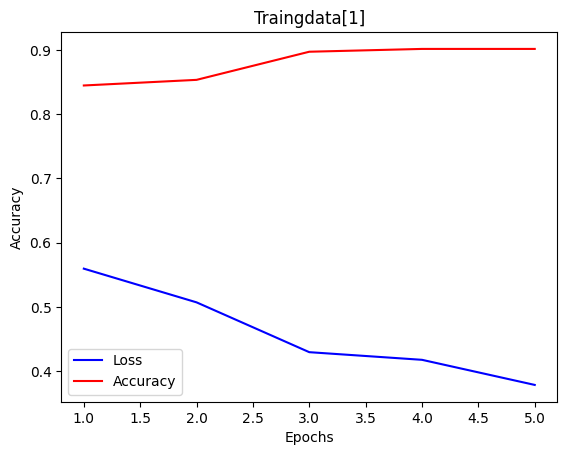

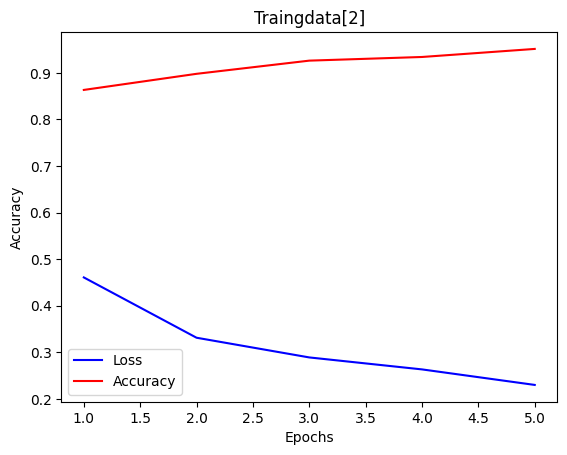

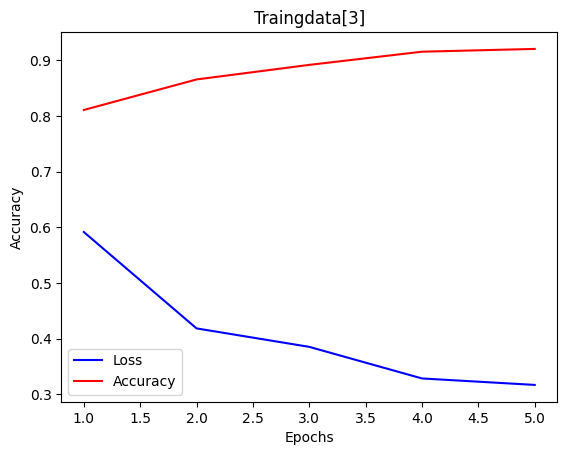

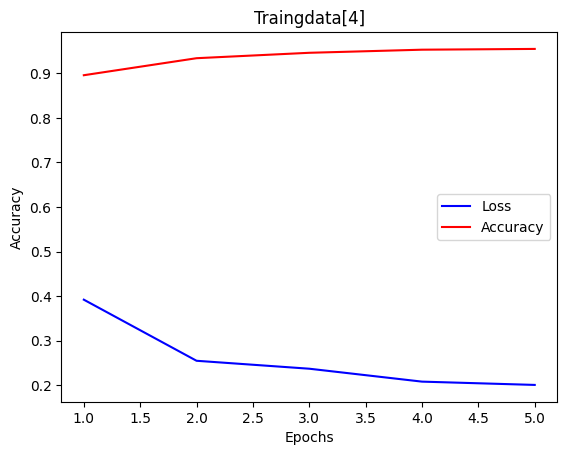

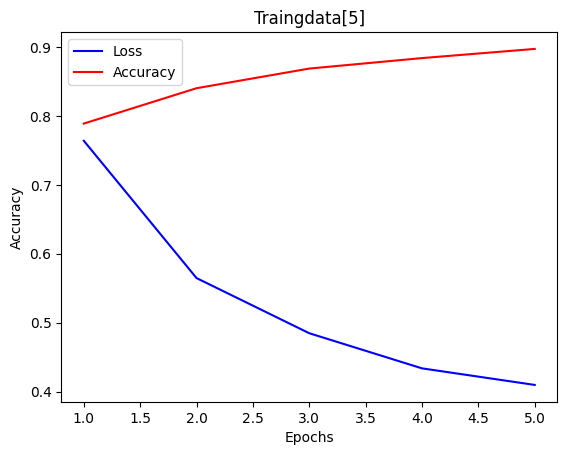

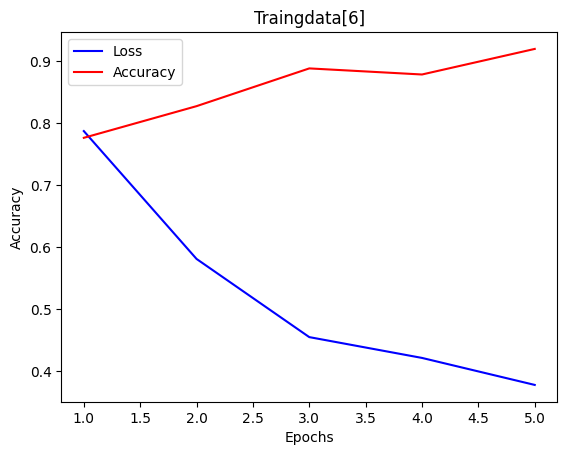

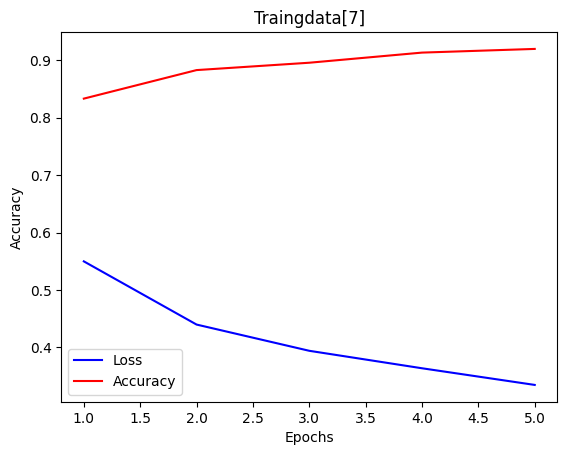

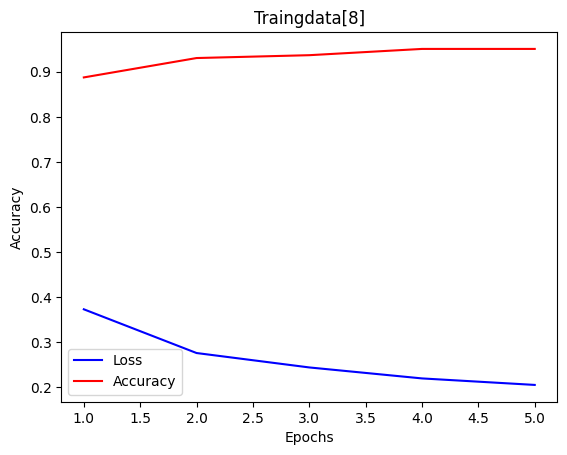

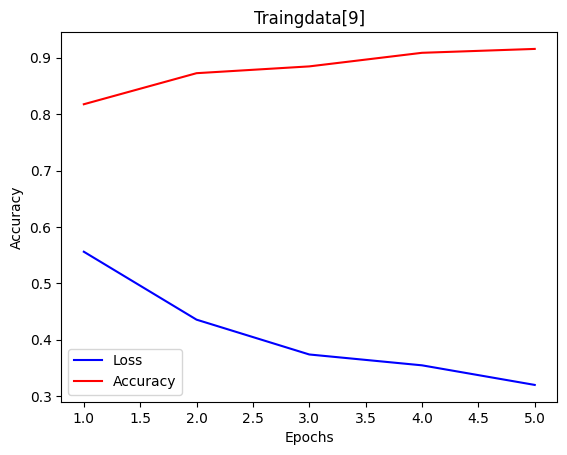

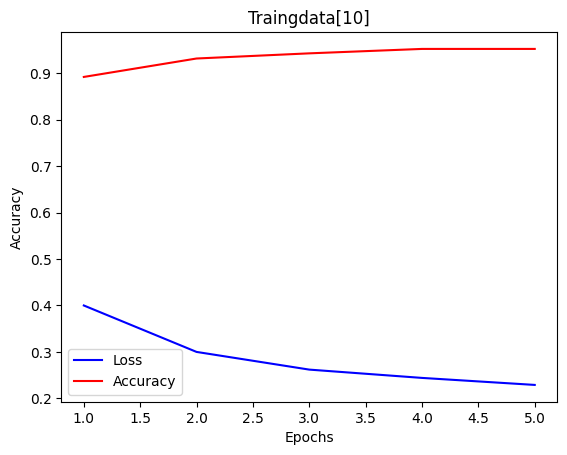

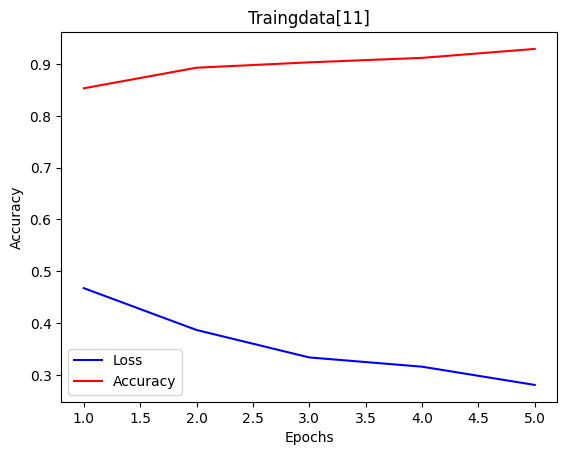

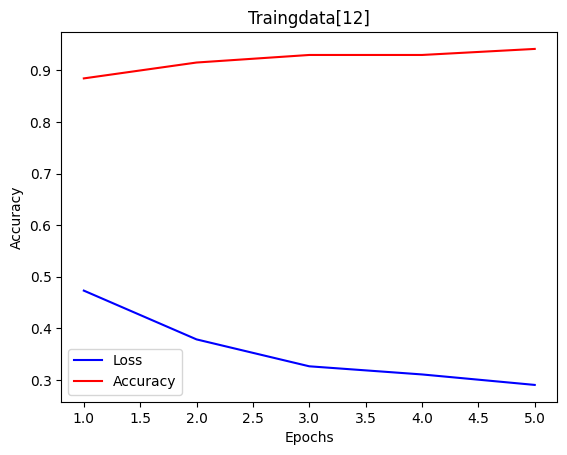

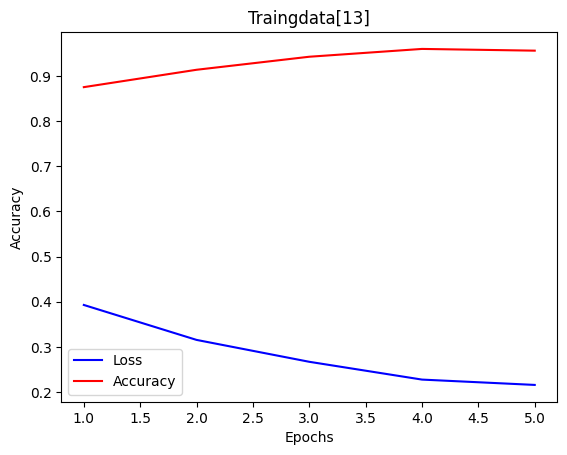

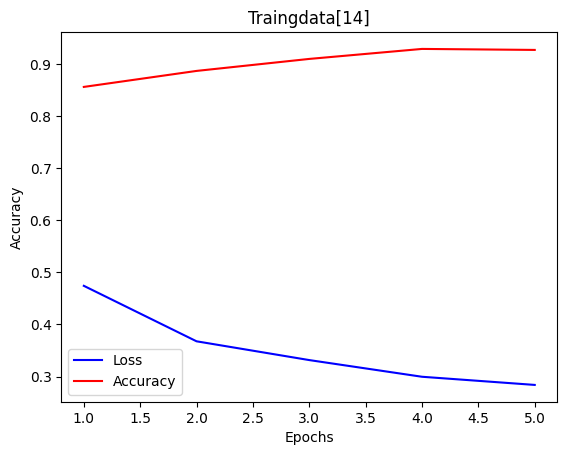

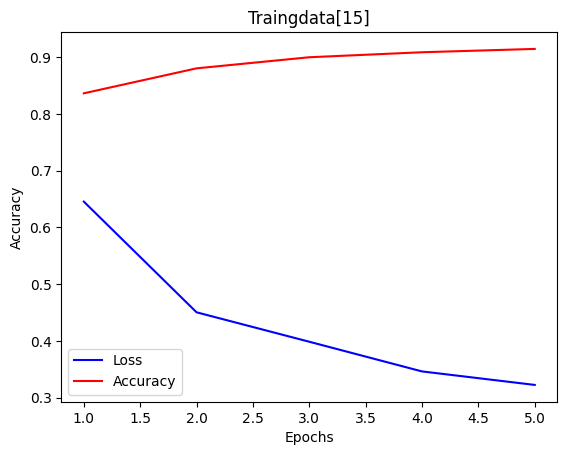

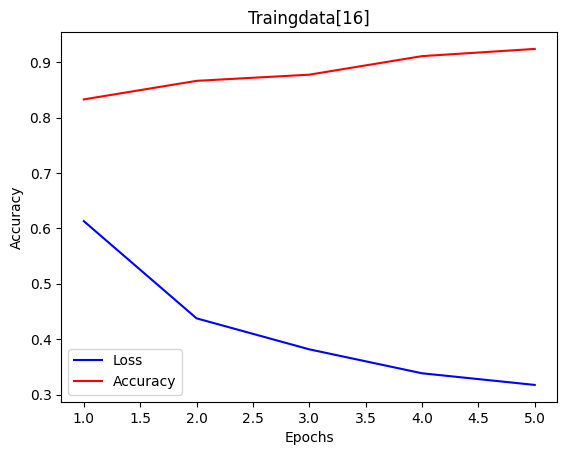

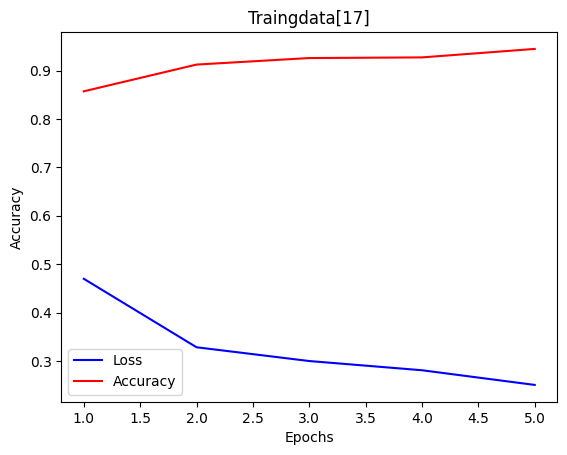

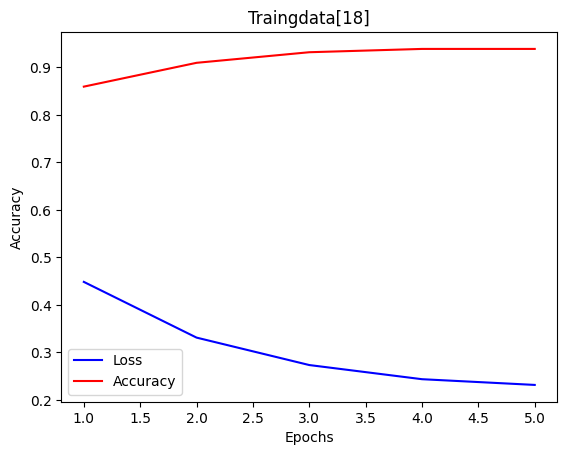

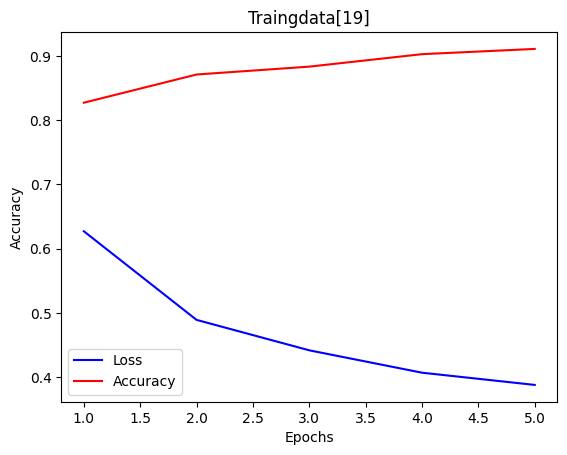

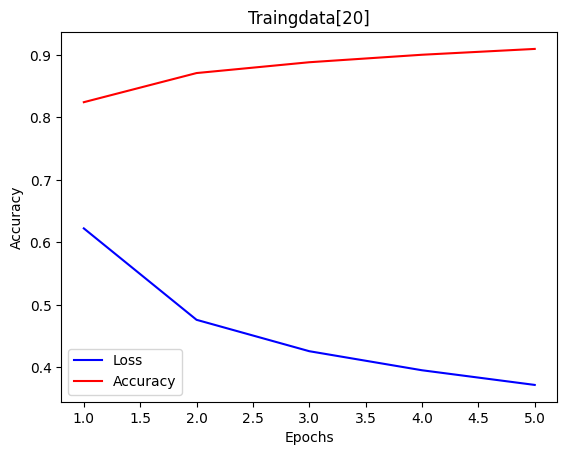

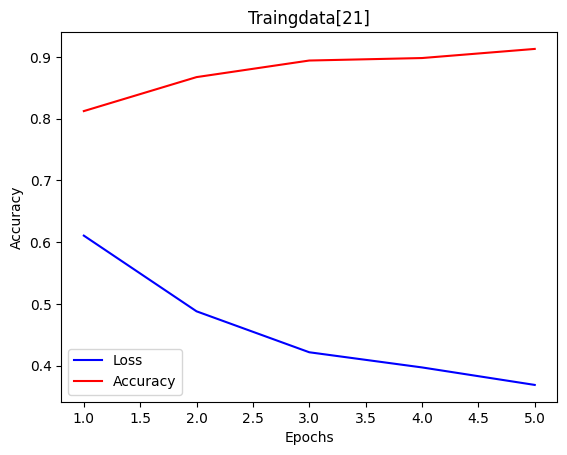

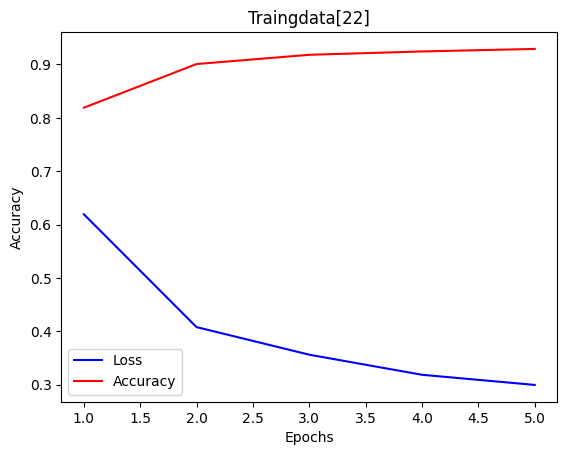

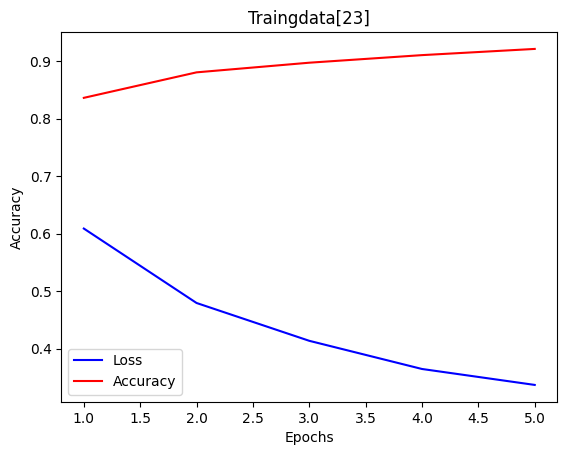

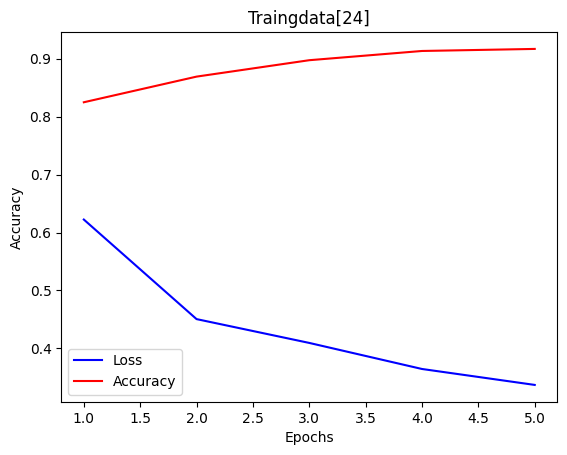

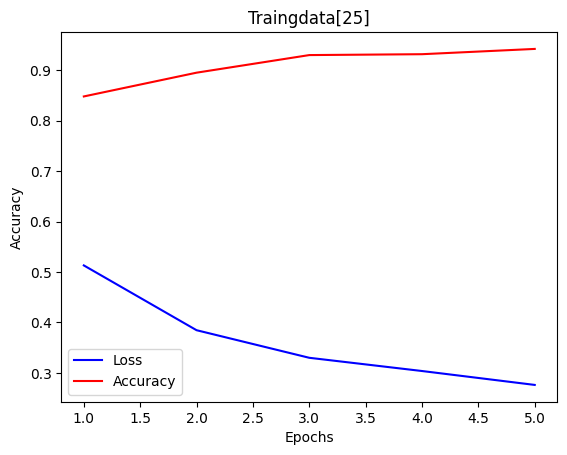

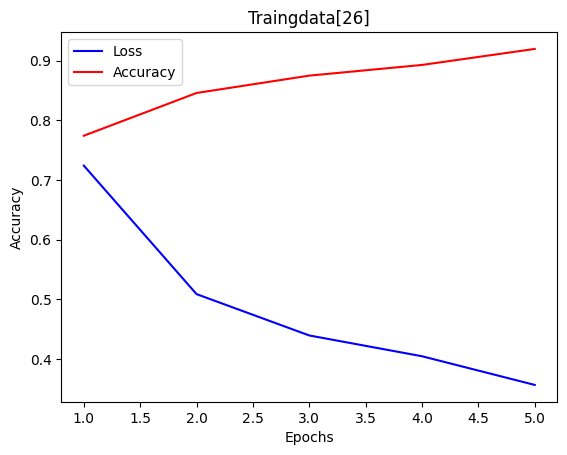

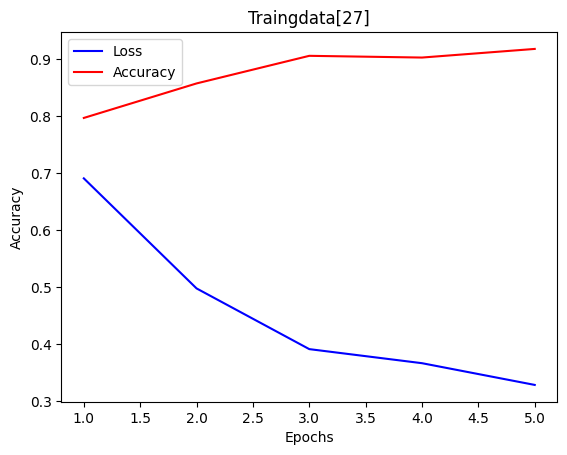

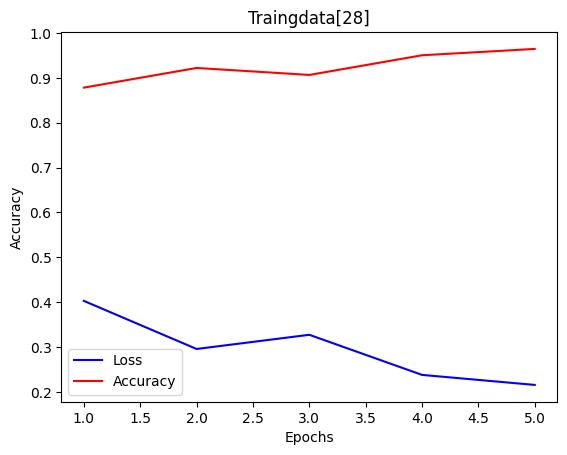

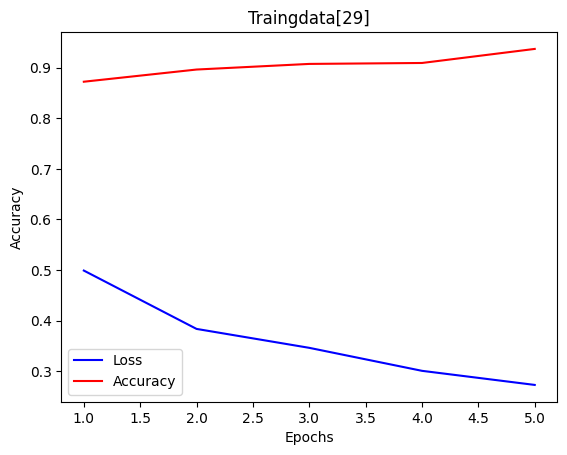

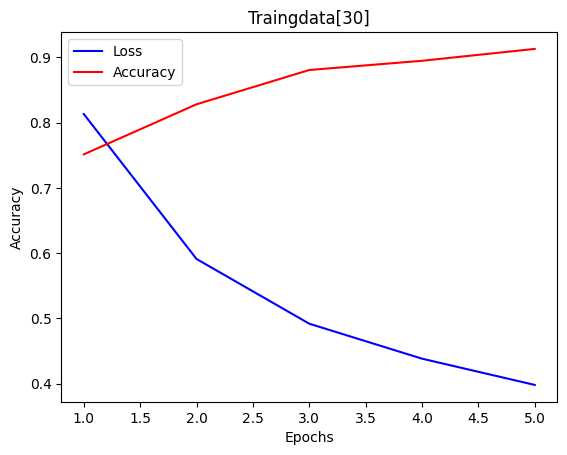

In [ ]:
  i = 0
  for x in all_history:
    i = i + 1
    show_history(x, "Traingdata[" + str(i) + "]")

In [ ]:
import keras
model = keras.models.load_model("drive/MyDrive/Webgen/lastChancheAlternative.h5")

#Postprocessing

In [ ]:
#@title
class Object:
    def __init__(self, id):
        self.id = id
        self.elements = None
        self.text = None

    def get_string(self):
        res = "id = " + "\"" + self.id + "\""
        if self.elements == None:
            return res
        return res + self.elements


In [ ]:
#@title
def get_object_dict(stuff_for_post_processing):
    object_dict = {}
    all_lines = stuff_for_post_processing.splitlines()
    for i in range(len(all_lines)):
        line = all_lines[i]
        if "object" in line:
            if ('{') in line:
                # abfangen von object objectname{ wenn nicht object name
                id = line.split('{')[0].split()[1]
                new_object = Object(id)
                #print(id)
                for i in range(i+1,len(all_lines)):
                    #print(i)
                    if '}' in all_lines[i]:
                        object_dict[id] = new_object
                        break
                    if '+' in all_lines[i]:
                        if new_object.elements == None:
                            new_object.elements = ""
                        new_object.elements = new_object.elements + " " + all_lines[i].split("+")[1]
                    if '-' in all_lines[i]:
                        new_object.text =   all_lines[i].split("-")[1]
            else:
                id = line.split()[1]
                new_object = Object(id)
                object_dict[id] = new_object
    return object_dict

In [ ]:
#@title
def remove_all_spaces_tokens(filled_HTML):
    filled_HTML = filled_HTML.replace("!STOP!","")
    filled_HTML = filled_HTML.replace("00SPACES ","")
    spaces = ""
    for i in range(10):
        filled_HTML = filled_HTML.replace("0"+ str(i) +  "SPACES ",spaces).replace(" - ", "-")
        spaces = spaces + " "
    for i in range(10,64):
        filled_HTML = filled_HTML.replace(str(i) +  "SPACES ",spaces).replace(" - ", "-")
        spaces = spaces + " "
    return filled_HTML

In [ ]:
#@title
def id_post_processing(stuff_for_post_processing, identifiers,stript_html):
    object_dict = get_object_dict(stuff_for_post_processing)
    for element in identifiers.keys():
        if (element + " " not in stript_html):
            continue
        id = identifiers[element]
        #print(element)
        fill_text = object_dict[id].get_string()
        #print(element)
        if object_dict[id].text is not None:
            cuttetElemement = stript_html.split(element + " ")
            #print(cuttetElemement[1])
            only_inside = cuttetElemement[1].split("<")#
            #print(element + " " + only_inside[0])
            #print(fill_text + " " + only_inside[0] + object_dict[id].text)
            stript_html = stript_html.replace(element + " " + only_inside[0], fill_text + " " + only_inside[0] + object_dict[id].text)
        else:
            stript_html = stript_html.replace(element + " ", fill_text + " ")
    return stript_html

add html frame

In [ ]:
#@title
def add_html_frame(string):
    with open("drive/MyDrive/Webgen/PlantUML_versuch/html_frame.txt", "r", encoding="utf-8") as file:
        file_content = file.read()
    html_frame = file_content.encode("ascii", "ignore").decode("utf-8")

    string = html_frame.replace("<!-- Content -->", string)

    return string

start post processing

In [ ]:
#@title
def post_processing(stuff_for_post_processing, identifiers,stript_html):

  # ids
  stript_html = id_post_processing(stuff_for_post_processing, identifiers, stript_html)

  # spaces
  stript_html = remove_all_spaces_tokens(stript_html)

  # HTML add frame
  stript_html = add_html_frame(stript_html)

  return stript_html

###Prediction

predict tokens -> html

In [ ]:
#@title
import numpy as np

def generate_tokens(type_input, order_input):

    # FAKE BATCH
    type_input = np.tile(type_input, (1, 1))
    order_input = np.tile(order_input, (1, 1))

    # GENERATED TOKENS
    generated_tokens = [174] # initially with <body

    for i in range(1000): # 1000 = Fallback break, if no stop token is generated

        # FAKE BATCH
        generated_tokens_batch = np.tile(generated_tokens, (1, 1))

        # PREDICT: next token
        prediction = model.predict([type_input, order_input, generated_tokens_batch])[0]
        predicted_token = np.argmax(prediction)

        # CHECK FOR STOP TOKEN
        if predicted_token == 1:
            break

        # Append the predicted token to the generated tokens array
        generated_tokens.append(predicted_token)

    return generated_tokens

#Usage

In [ ]:

#@title
def usage():

    # READ: PlantUML
    with open("drive/MyDrive/Webgen/PlantUML_versuch/training_pairs/plantUML/1.txt", "r", encoding="utf-8") as file:
        file_content = file.read()
    input = file_content.encode("ascii", "ignore").decode("utf-8")

    # PREPROCESSING: PlantUML
    stuff_for_post_processing, identifiers, type_input, order_input = plant_uml_preprocessing(input)

    type_input  = np.array(tokenizer.texts_to_sequences([type_input] ))[0]
    order_input = np.array(tokenizer.texts_to_sequences([order_input]))[0]

    # GENERATE TOKENS
    tokens = generate_tokens(type_input, order_input)

    # TOKENS -> HTML
    html = tokenizer.sequences_to_texts([tokens])[0]
    with open("drive/MyDrive/Webgen/PlantUML_versuch/test1.html", "w", encoding="utf-8") as file:
        file.write(html)
    return html
    # HTML + stuff_for_post_processing
    html = post_processing(stuff_for_post_processing, identifiers, html)

    # WRITE: html
    with open("drive/MyDrive/Webgen/PlantUML_versuch/test2.html", "w", encoding="utf-8") as file:
        file.write(html)




In [ ]:
def test_usage_with_data_set():
    number = random.randint(1, 30)

    with open(f"drive/MyDrive/Webgen/PlantUML_versuch/training_pairs/plantUML/{2}.txt", "r", encoding="windows-1255") as file:
        file_content = file.read()
    input = file_content.encode("ascii", "ignore").decode("utf-8")
        # PREPROCESSING: PlantUML
    stuff_for_post_processing, identifiers, type_input, order_input = plant_uml_preprocessing(input)

    type_input  = np.array(tokenizer.texts_to_sequences([type_input] ))[0]
    order_input = np.array(tokenizer.texts_to_sequences([order_input]))[0]

    # GENERATE TOKENS
    tokens = generate_tokens(type_input, order_input)

    # TOKENS -> HTML
    html = tokenizer.sequences_to_texts([tokens])[0]
    return html

In [ ]:
#@title
html = test_usage_with_data_set()

1/1 [==============================] - 0s 126ms/step


In [ ]:
def add_new_line_2():
  inputs, outputs = create_dataset()
  output = tokenizer.sequences_to_texts([outputs])[0]
  all_outputs = output.split()
  ergebniss = ""
  for x in all_outputs:
    if "spaces" in x:
      ergebniss += "\n" + x + " "
    else:
      ergebniss += x + " "

In [ ]:
print(html)

<body > 04spaces <header id11 class = " container - fluid bg - light " > 08spaces <div class = " container " > 12spaces <img id11 class = " img - fluid " > 08spaces </div > 08spaces <nav id5 class = " navbar navbar - expand - lg navbar - light bg - light " > 12spaces <a id19 class = " navbar - brand text - dark " > </a > 12spaces <button class = " navbar - toggler " - toggle = " collapse " - 16spaces - = " " - = " " - label = " toggle " > 16spaces <span class = " navbar - toggler - icon " > </span > 12spaces </button > 12spaces <div class = " collapse navbar - collapse " > 16spaces <ul class = " navbar - nav ml - auto " > 20spaces <li class = " nav - item " > 24spaces <a id22 class = " nav - link text - dark " > </a > 20spaces </li > 20spaces <li class = " nav - item " > 24spaces <a id15 class = " nav - link text - dark " > </a > 20spaces </li > 20spaces <li class = " nav - item " > 24spaces <a id9 class = " nav - link text - dark " > </a > 20spaces </li > 20spaces <li class = " nav - 

In [ ]:
def add_new_line(html):
  all_outputs = html.split()
  result = ""
  for x in all_outputs:
    if "spaces" in x:
      result += "\n" + x + " "
    else:
      result += x + " "
  return result

In [ ]:
newhtml = add_new_line(html)

In [ ]:
print(newhtml)

<body > 
04spaces <header id11 class = " container - fluid bg - light " > 
08spaces <div class = " container " > 
12spaces <img id11 class = " img - fluid " > 
08spaces </div > 
08spaces <nav id5 class = " navbar navbar - expand - lg navbar - light bg - light " > 
12spaces <a id19 class = " navbar - brand text - dark " > </a > 
12spaces <button class = " navbar - toggler " - toggle = " collapse " - 
16spaces - = " " - = " " - label = " toggle " > 
16spaces <span class = " navbar - toggler - icon " > </span > 
12spaces </button > 
12spaces <div class = " collapse navbar - collapse " > 
16spaces <ul class = " navbar - nav ml - auto " > 
20spaces <li class = " nav - item " > 
24spaces <a id22 class = " nav - link text - dark " > </a > 
20spaces </li > 
20spaces <li class = " nav - item " > 
24spaces <a id15 class = " nav - link text - dark " > </a > 
20spaces </li > 
20spaces <li class = " nav - item " > 
24spaces <a id9 class = " nav - link text - dark " > </a > 
20spaces </li > 
20space